# Memory task machine learning
## Matt Oberhardt

### Initial setup

In [8]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%matplotlib inline  


## set options ##

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so i can see all rows of dfs
pd.set_option('display.max_columns', 500)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

## import my memorytools module ##

import memorytools as mt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load up the memory & demographic data:

# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)

# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

# add memory composite features:
data = mt.add_composite_features_to_data(data)

Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)
memory features loaded from file: memory_data_with_features.p (input data was ignored)
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Machine learning setup

In [13]:
from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

### deal with age confound

In [9]:
# load feature categories
fcats = mt.define_feature_categories()

# define features
features = fcats['game'] + fcats['demographic'] + fcats['output']
features.remove('medTimepoint')
features_df = data[features]
features_df = mt.convert_features_to_numbers(features_df)
print 'NOTE: need to deal with medTimepoint in mt.convert_features_to_numbers())'

features_df.head(2)


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['gender', 'education']
NOTE: need to deal with medTimepoint in mt.convert_features_to_numbers())


,game_numFails,game_score,game_numGames,9_numsuccesses,9_numunsuccesses,9_meandist,9_successful,9_gamescore,9_latency,9_firstdist,9_meanDt,9_meansuccessfuldist,16_firstdist,16_meandist,16_numsuccesses,16_gamescore,16_latency,16_numunsuccesses,16_successful,16_meanDt,16_meansuccessfuldist,played_game4,age,gender,education,hasParkinsons,brainStim,surgery,nyearsOnMeds,nyearsOffMeds,nyearsParkinsons
0,0,400,5,3.500000,0,13.530960,1,52.5,1.473971,10.884290,0.246723,13.530960,18.086166,16.358862,6.0,98.333333,0.752558,0.0,1.0,0.333105,16.358862,False,43,1,8,False,False,False,NaN,NaN,2
1,1,285,5,3.666667,0,18.878599,1,55.0,1.021844,23.426046,0.240136,18.878599,18.193884,17.841529,4.5,60.000000,2.246608,0.5,0.5,0.714662,17.521532,False,43,1,8,False,False,False,NaN,NaN,2


RanksumsResult(statistic=-0.7817819535312025, pvalue=0.43434272854289224)


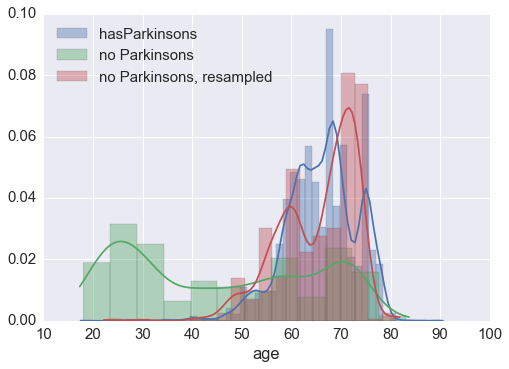

In [10]:
# resample non-Park to same age distribution as Parkinsons:
df = features_df
distcol = 'age'
splitcol = 'hasParkinsons'
splitVal_resample = False
splitVal_guide = True
nbins = 10
nResamples = 600
df_resampled, df_guide, df_resample = mt.resample_to_match_distribution(df, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
df_resampled_np = df_resampled
df_Parkinsons = df_guide
df_np = df_resample

sns.distplot(df_guide[distcol].dropna(), label='hasParkinsons')
sns.distplot(df_resample[distcol].dropna(), label='no Parkinsons')
sns.distplot(df_resampled[distcol].dropna(), label='no Parkinsons, resampled')
plt.legend(loc=2)

x = df_resampled[distcol].dropna().values
y = df_guide[distcol].dropna().values
p2 = ranksums(x, y)
print p2

RanksumsResult(statistic=-5.4758855228381487, pvalue=4.3532906635332229e-08)


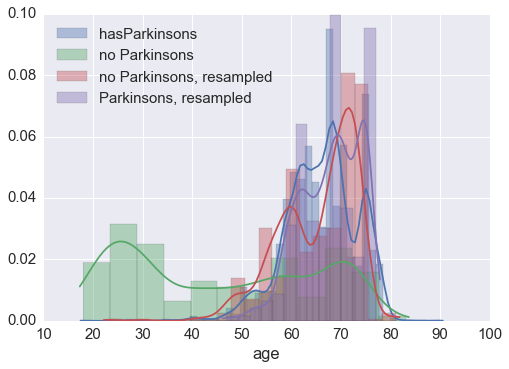

In [11]:
# resample Park to the resampled non-Park for sample balancing:
# resample non-Park to same age distribution as Parkinsons:
df = df_resampled_np.append(df_Parkinsons)
distcol = 'age'
splitcol = 'hasParkinsons'
splitVal_resample = True
splitVal_guide = False
df_resampled, df_guide, df_resample = mt.resample_to_match_distribution(df, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
df_resampled_Park = df_resampled


sns.distplot(df_Parkinsons[distcol].dropna(), label='hasParkinsons')
sns.distplot(df_np[distcol].dropna(), label='no Parkinsons')
sns.distplot(df_resampled_np[distcol].dropna(), label='no Parkinsons, resampled')
sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
plt.legend(loc=2)

x = df_resampled_np[distcol].dropna().values
y = df_resampled_Park[distcol].dropna().values
p2 = ranksums(x, y)
print p2

In [15]:
### Redo machine learning with these sets:
df = df_resampled_np.append(df_resampled_Park)
features = fcats['game'] + ['hasParkinsons']# + fcats['demographic'] + fcats['output']
#features = ['9_firstdist', '9_meansuccessfuldist', '16_meansuccessfuldist', '9_latency', '16_meanDt', '9_meanDt', 'hasParkinsons']
#features = [ '16_meansuccessfuldist', '9_latency', '16_meanDt', '9_meanDt', 'hasParkinsons']

labelcol = 'hasParkinsons'
#mt.display_num_nulls_per_column(df[features])

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False)       


# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

###### assess performance:
mod.fit(X_train, y_train)
print 'training accuracy:', mod.score(X_train, y_train)
print 'test accuracy:', mod.score(X_test, y_test) 
print 'num actual positives = %s' % sum(y)
print 'num actual negatives = %s' % (len(y) - sum(y))
print 'random accuracy would be %s' % (float(sum(y))/len(y))
print '\n'

# which features matter?
#print mat
mat = mod.predict_proba(X_test)

print 'feature importances:'
S = pd.Series(mod.feature_importances_, index=X_names, name="feature importances")
print S.sort_values()


#  Confusion matrix:
y_pred = mod.predict(X_test)
sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)



training accuracy: 1.0
test accuracy: 0.790368271955
num actual positives = 583
num actual negatives = 591
random accuracy would be 0.496592844974


feature importances:
game_numGames            0.000000
played_game4             0.000524
9_numunsuccesses         0.002963
9_successful             0.003102
game_numFails            0.005308
9_gamescore              0.008479
9_numsuccesses           0.010519
16_numunsuccesses        0.011083
16_successful            0.011921
16_numsuccesses          0.029730
16_gamescore             0.031321
game_score               0.034882
16_firstdist             0.055266
9_firstdist              0.057070
16_meandist              0.066117
9_latency                0.066955
9_meansuccessfuldist     0.068487
16_latency               0.069853
9_meandist               0.074120
16_meansuccessfuldist    0.078265
16_meanDt                0.150797
9_meanDt                 0.163238
Name: feature importances, dtype: float64


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


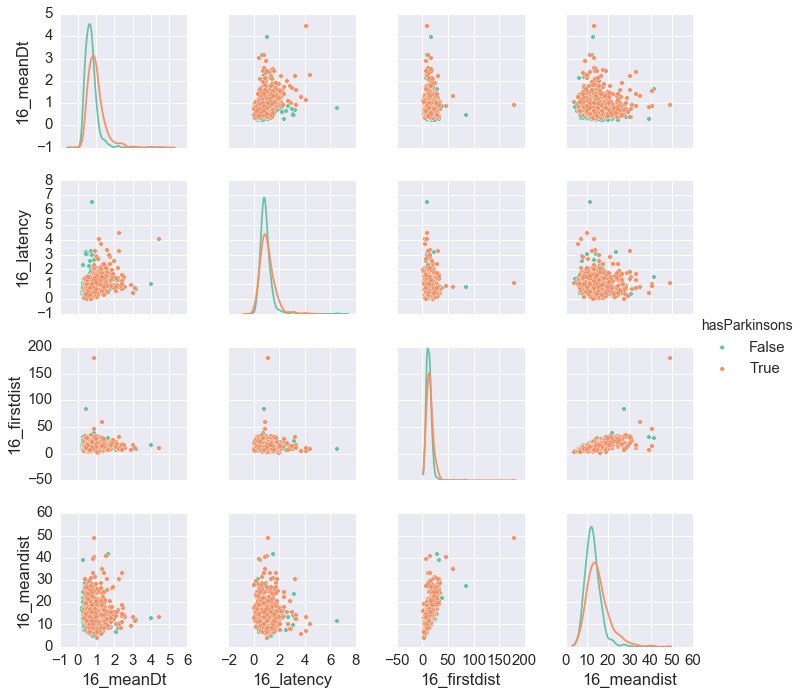

In [16]:
# visualize this new dataset (resampled):

#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
#features_df = data[["game_score",'16_gamescore','hasParkinsons']]
fplot = features_df[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
#fplot = fplot.dropna()
g = sns.pairplot(fplot, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)



In [ ]:
# To Do:

# package the resampling code into a function

# add age back in as variable now, and rerun random forest
# try logistic regression, with l1 (lasso) (minimize # features)

# do pca of outputs, and see if we can be more predictive
# split data by person and check on drugs vs not on drugs (what is predictive)
# time series analysis of indiv. patients, looking at the yes and no data?
# symptom variance individual patients plot?
# run rand forest with all in-game features & sample balancing but not correction for age

